In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))


import torch.nn as nn
from metrics.charts import ChartUtil
from metrics.charts import TrainingCharts
from datasets.xor import XOR
from training.train import TrainUtil

In [31]:
dataset = XOR()
in_features = 5
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique=False)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)

In [32]:
from layers.customLinearLayer import CustomLinearLayer
from layers.hippocampusLayer import HippocampusLayer
from layers.neoCortexLayer import NeoCortexLayer


class MarrsTwoLayerModel(nn.Module):
    def __init__(self, in_features = in_features, 
                 out_features = out_features,
                 memory_size = 1000,
                 first_layer_out_features = 10,
                 second_layer_out_features = 1000,
                 alpha = 0.02):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.memory_size = memory_size
        self.hippocampal_connections = second_layer_out_features
        self.hippocampal_L_value = int(alpha * second_layer_out_features)
        self.indicator_cells = first_layer_out_features

        self._neo_cortex = NeoCortexLayer(self.in_features,
                                      memory_size = self.memory_size,
                                      out_features = self.indicator_cells,
                                      hippocampol_connections=self.hippocampal_connections,)
        
        self._hippocampus = HippocampusLayer(self.indicator_cells, 
                                            self.hippocampal_connections, 
                                            out_features_allowed= self.hippocampal_L_value)
        
        self._recalled_output = CustomLinearLayer(memory_size, out_features)

    def forward(self, x):
        x_l1 = self._neo_cortex(x)
        x_l2 = self._hippocampus(x_l1)
        x_l3 = self._neo_cortex.coritcal_memory(x_l2)
        out = self._recalled_output(x_l3)
        return out

In [38]:
def perform_one_cortical_experiment(n_epochs = 41, 
                          n_runs=60,
                          in_features = in_features, 
                          out_features = out_features,
                          memory_size = 1000,
                          first_layer_out_features = 10,
                          second_layer_out_features = 1000,
                          alpha = 0.02,
                          trainUtil = trainUtil,
                          print_summary = False,
                          batch_train = False):
    chartUtil = ChartUtil()
    epoch_num = n_epochs
    for _ in range(n_runs):
        marrsTwoLayerModel = MarrsTwoLayerModel(
                          in_features = in_features, 
                          out_features = out_features,
                          memory_size = memory_size,
                          first_layer_out_features = first_layer_out_features,
                          second_layer_out_features = second_layer_out_features,
                          alpha = alpha
                          )
        
        loss_over_epochs, accuracy_over_epochs, epoch_numbers, train_accuracy, val_accuracy = trainUtil.train_and_evaluate(marrsTwoLayerModel, 
                                                                                                                           epochs=epoch_num, 
                                                                                                                           name="Marrs Two Layer Model",
                                                                                                                           print_msg=print_summary,
                                                                                                                           batch_train=batch_train)
        chartUtil.add_train_data("Marrs Two Layer Model", loss_over_epochs, accuracy_over_epochs, epoch_numbers)
        chartUtil.add_test_data("Marrs Two Layer Model", train_accuracy, val_accuracy)
    
    return chartUtil

In [61]:

chart_marrs_model = perform_one_cortical_experiment(n_epochs = 100, 
                                                    n_runs= 5, 
                                                    print_summary=True,
                                                    memory_size = 700,
                                                    first_layer_out_features = 20,
                                                    second_layer_out_features = 100,
                                                    alpha = 0.2,
                                                    batch_train = True)

Epoch 0, Loss: 0.6951
Epoch 10, Loss: 0.7107
Epoch 20, Loss: 0.7010
Epoch 30, Loss: 0.6922
Epoch 40, Loss: 0.6658
Epoch 50, Loss: 0.9505
Epoch 60, Loss: 0.2973
Epoch 70, Loss: 0.0031
Epoch 80, Loss: 0.9931
Epoch 90, Loss: 0.5668
Marrs Two Layer Model Train Accuracy: 84.3750, Val Accuracy: 84.3750
Epoch 0, Loss: 0.6922
Epoch 10, Loss: 0.6964
Epoch 20, Loss: 0.7102
Epoch 30, Loss: 0.6026
Epoch 40, Loss: 0.4978
Epoch 50, Loss: 0.3008
Epoch 60, Loss: 0.1018
Epoch 70, Loss: 0.2889
Epoch 80, Loss: 7.0152
Epoch 90, Loss: 0.5978
Marrs Two Layer Model Train Accuracy: 81.2500, Val Accuracy: 81.2500
Epoch 0, Loss: 0.6927
Epoch 10, Loss: 0.7073
Epoch 20, Loss: 0.6338
Epoch 30, Loss: 0.5499
Epoch 40, Loss: 0.4976
Epoch 50, Loss: 0.4299
Epoch 60, Loss: 0.3113
Epoch 70, Loss: 0.6013
Epoch 80, Loss: 0.9480
Epoch 90, Loss: 0.6149
Marrs Two Layer Model Train Accuracy: 62.5000, Val Accuracy: 62.5000
Epoch 0, Loss: 0.6938
Epoch 10, Loss: 0.6981
Epoch 20, Loss: 0.6826
Epoch 30, Loss: 0.6654
Epoch 40, Loss:

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_73732/1294657487.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  training_loss.show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_73732/1294657487.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  training_acc.show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_73732/1294657487.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  test_acc.show()


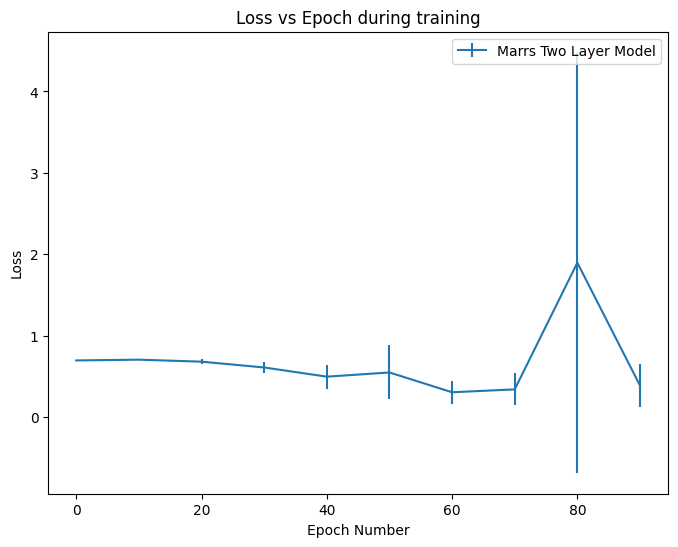

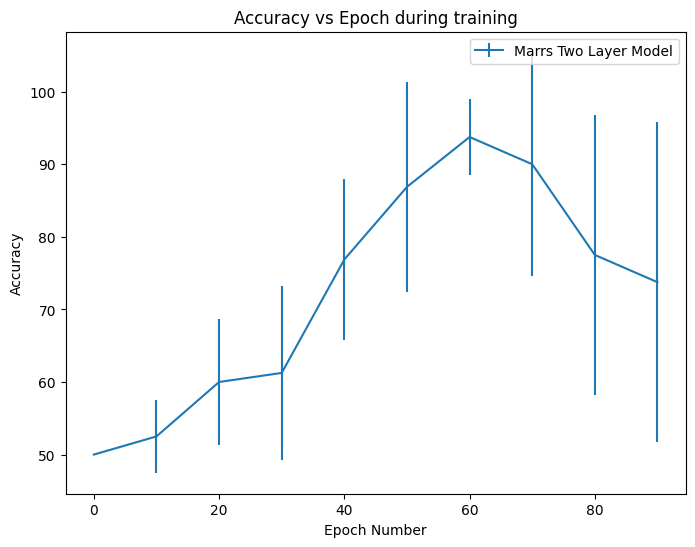

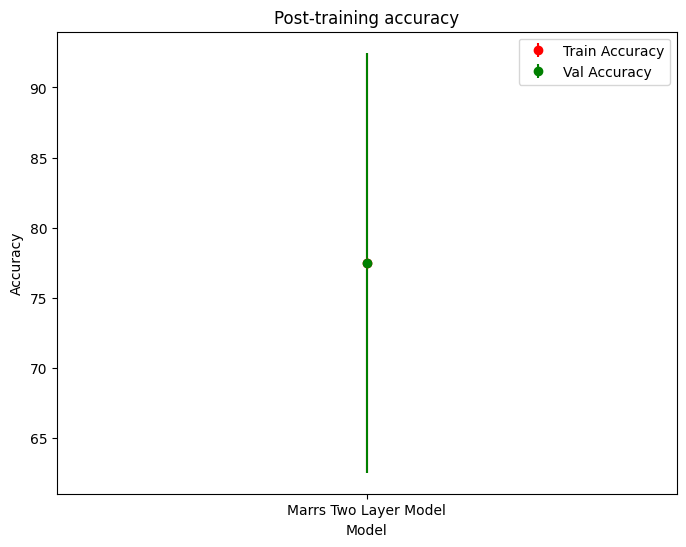

In [62]:
training_loss = chart_marrs_model.plot_training_data_for()
training_acc = chart_marrs_model.plot_training_data_for(TrainingCharts.ACC)
test_acc = chart_marrs_model.plot_test_accu_for_models()
training_loss.show()
training_acc.show()
test_acc.show()